In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import warnings
pd.set_option('max_columns', 100)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

In [2]:
# Read in the data CSV files
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
ss = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

In [3]:
print("train.csv shape: ", train.shape)
print("train_labels.csv shape: ", train_labels.shape)
print("test.csv shape: ", test.shape)
print("specs.csv shape: ", specs.shape)

train.csv shape:  (11341042, 11)
train_labels.csv shape:  (17690, 7)
test.csv shape:  (1156414, 11)
specs.csv shape:  (386, 3)


In [4]:
train_ = train.sample(1000000) # sample for efficient plot

## train.csv

- event_id - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- game_session - Randomly generated unique identifier grouping events within a single game or video play session.
- timestamp - Client-generated datetime
- event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.
- installation_id - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- event_count - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- event_code - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- game_time - Time in milliseconds since the start of the game session. Extracted from event_data.
- title - Title of the game or video.
- type - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- world - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [5]:
# because there are installation_ids which don't include assessments, these examples are removed.
# to remove data which never took assessments
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

In [6]:
train.head(10)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
5,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK
6,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:19.365Z,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06T04:58:21.490Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK
8,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:22.732Z,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK
9,5e812b27,2b9d5af79bcdb79f,2019-08-06T04:58:23.295Z,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8294138 entries, 0 to 8294137
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 759.4+ MB


In [8]:
train.describe()

,event_count,event_code,game_time
count,8.294138e+06,8.294138e+06,8.294138e+06
mean,9.881407e+01,3.511168e+03,1.697724e+05
std,1.324557e+02,6.786188e+02,1.054264e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.400000e+01,3.021000e+03,2.926700e+04
50%,5.800000e+01,4.020000e+03,6.971500e+04
75%,1.220000e+02,4.035000e+03,1.492790e+05
max,3.182000e+03,5.010000e+03,3.069102e+08


In [9]:
train.isnull().sum() # no missing values in all the datasets

event_id           0
game_session       0
timestamp          0
event_data         0
installation_id    0
event_count        0
event_code         0
game_time          0
title              0
type               0
world              0
dtype: int64

In [10]:
# to check if event_id & game_session are randomly gegerated
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

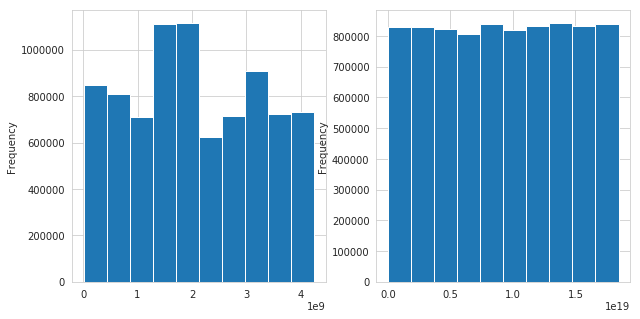

In [11]:
# However, nothing intertesting is showed.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
train['event_id_as_int'].plot(kind="hist")
plt.subplot(1,2,2)
train['game_session_as_int'].plot(kind="hist")

In [12]:
# Format and make date / hour features
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name
# Same for test
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

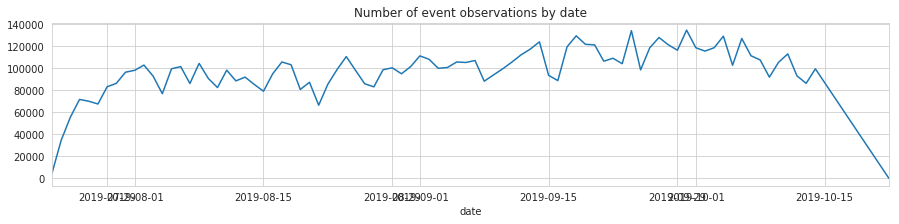

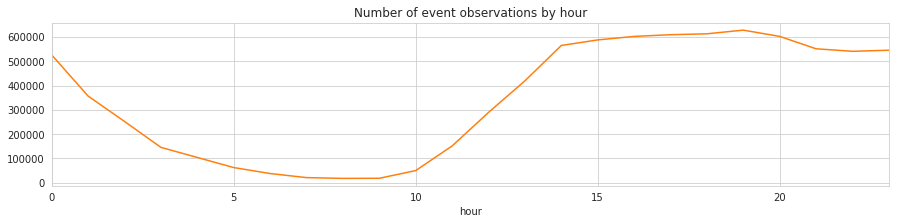

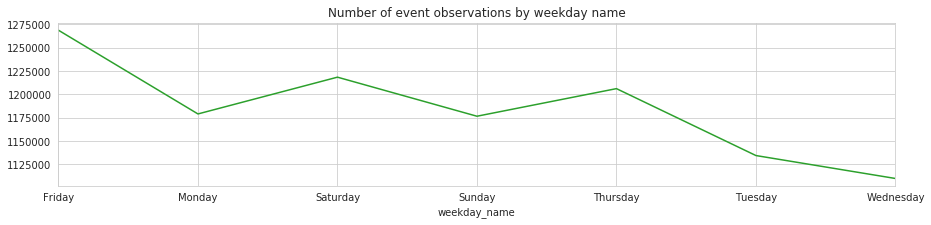

In [13]:
train.groupby('date')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by date", color=my_pal[0])
plt.show()
train.groupby('hour')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by hour", color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by weekday name", color=my_pal[2])
plt.show()

In [14]:
# event data: which seems to have the most interesting information, however, considering the RAM limit, it's necessary to exract only the influential information.
print(train["event_data"][4])
print(train["event_data"][5])

{"coordinates":{"x":273,"y":650,"stage_width":1015,"stage_height":762},"event_count":3,"game_time":2137,"event_code":4070}
{"coordinates":{"x":863,"y":237,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":3937,"event_code":4070}


In [15]:
# installation_id
train["installation_id"].nunique()

4242

In [16]:
# there are no installation_id's that appear in both train and test.
set(list(train.installation_id.unique())).intersection(set(list(test.installation_id.unique())))

set()

In [17]:
# date range
test['timestamp'] = pd.to_datetime(test['timestamp'])
print(f'The date range in train is: {train.timestamp.dt.date.min()} to {train.timestamp.dt.date.max()}')
print(f'The date range in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')
# we are talking about a dataset that seems (randomly) split on installation_id. 
# Well actually "sort of" as Kaggle seems to have done this on installation_id's with assessments first, and added the "left-overs" with no assessments taken to the train set.

The date range in train is: 2019-07-23 to 2019-10-22
The date range in test is: 2019-07-24 to 2019-10-14


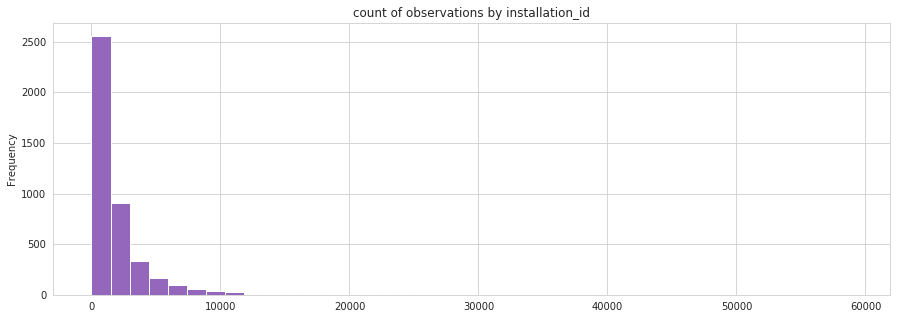

In [18]:
train.groupby('installation_id').count()['event_id'].plot(kind="hist",
          bins=40,
          color=my_pal[4],
          figsize=(15, 5), title="count of observations by installation_id")

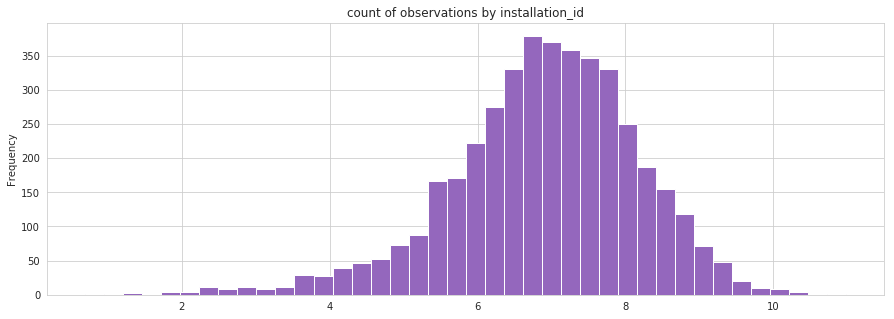

In [19]:
# take log transformation because the original data looks skewed
train.groupby('installation_id').count()['event_id'].apply(np.log1p).plot(kind="hist",
          bins=40,
          color=my_pal[4],
          figsize=(15, 5), title="count of observations by installation_id")

In [20]:
# what is the highest number of cases of installation_id
train['installation_id'].value_counts().head(3)

f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
Name: installation_id, dtype: int64

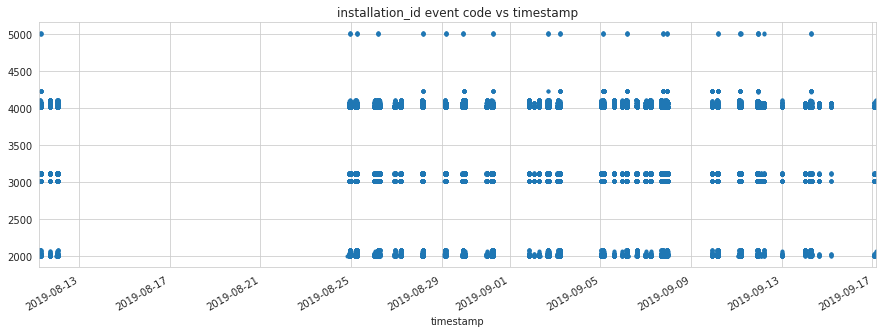

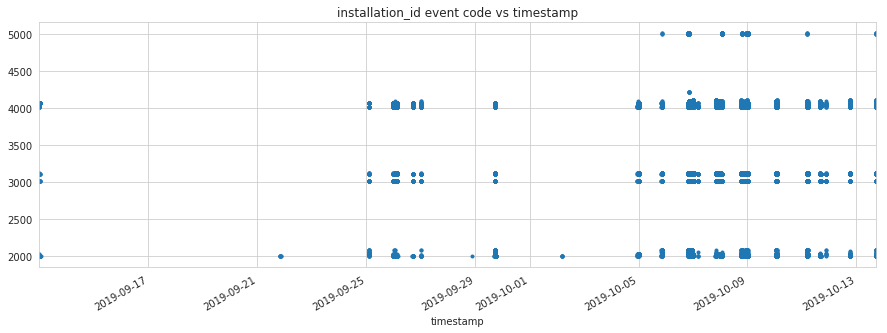

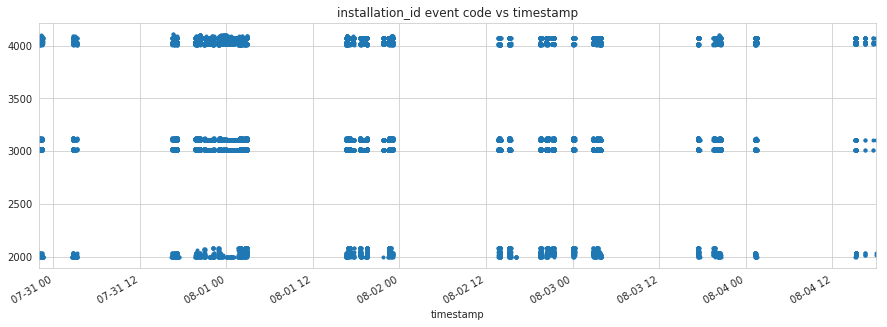

In [21]:
train.query('installation_id == "f1c21eda"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()
train.query('installation_id == "4d7d3d97"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()
train.query('installation_id == "d25338cb"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()

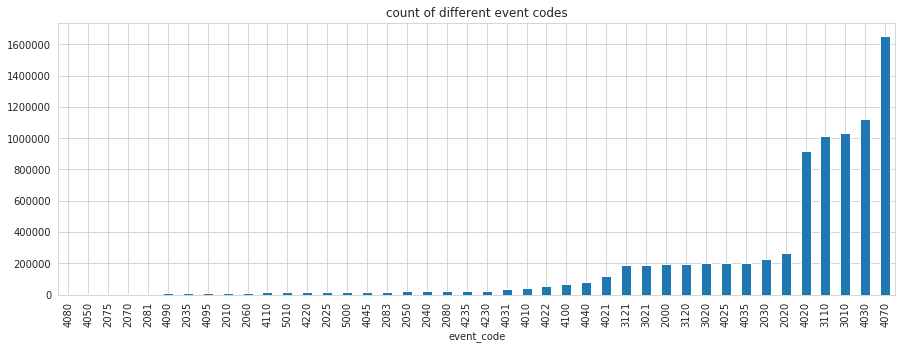

In [22]:
# event_code: looks loke dictionary format but string
train.groupby("event_code").count()["event_id"].sort_values().plot(kind="bar", figsize=(15,5), title="count of different event codes")

4070 and 4030 always come with coordinates (x, y) adn stage_width
possibly they could be marking achievement or something related to position on the screen. These events look like this
- {"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}


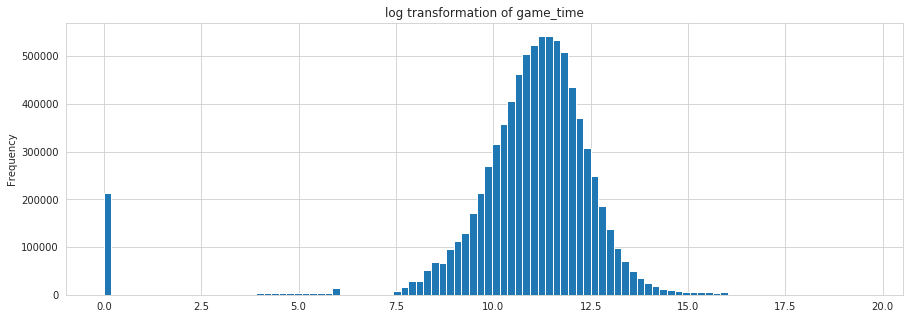

In [23]:
# game_time: almost similar to normal distribution
train["game_time"].apply(np.log1p).plot(kind="hist", figsize=(15,5), bins=100, title="log transformation of game_time")

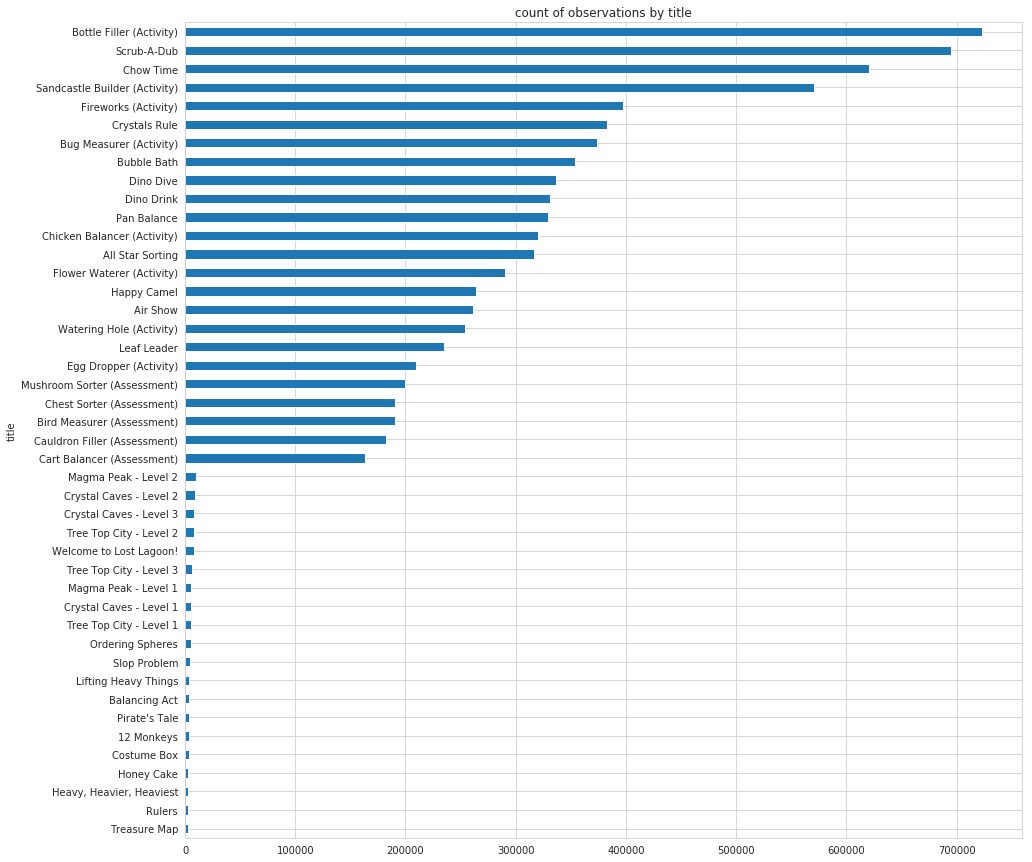

In [24]:
# game/video titles
train.groupby("title")["event_id"].count().sort_values().plot(kind="barh", title="count of observations by title", figsize=(15,15))

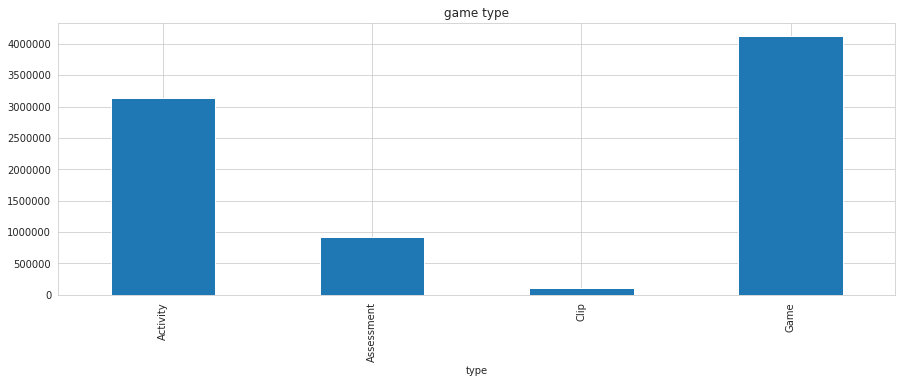

In [25]:
# game type
train.groupby("type").count()["event_id"].plot(kind="bar", figsize=(15,5), title = "game type")

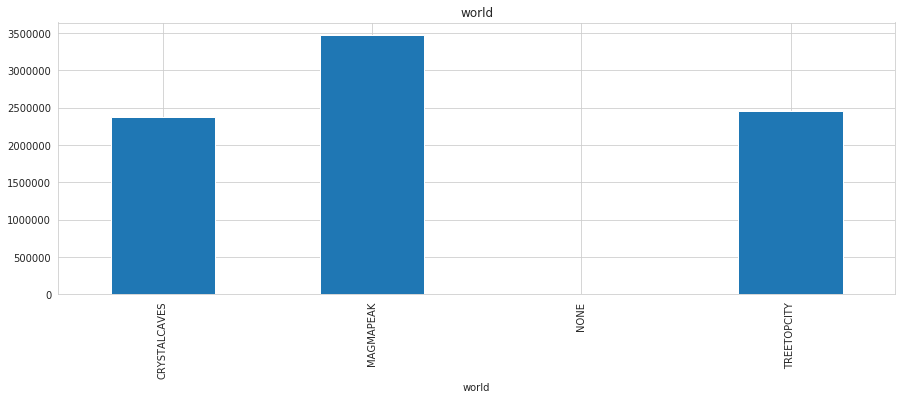

In [26]:
# world 
train.groupby("world").count()["event_id"].plot(kind="bar", figsize=(15,5), title = "world")

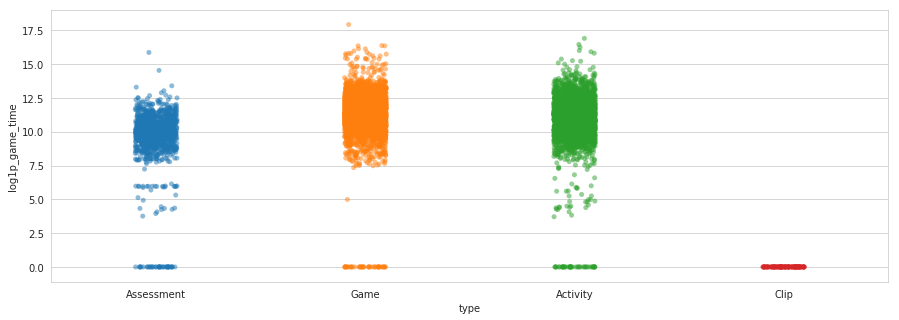

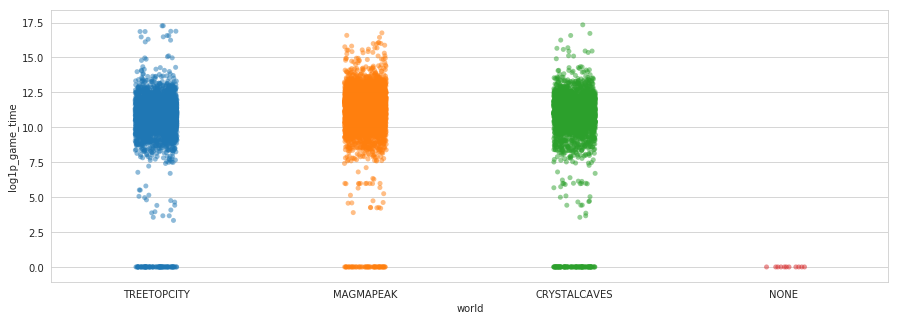

In [27]:
train["log1p_game_time"] = train["game_time"].apply(np.log1p)
fig, ax = plt.subplots(figsize=(15,5))
sns.catplot(x="type", y = "log1p_game_time", data=train.sample(10000), alpha=0.5, ax=ax)
plt.close()
fig, ax = plt.subplots(figsize=(15,5))
sns.catplot(x="world", y="log1p_game_time", data=train.sample(10000), alpha=0.5, ax=ax)
plt.close()

# train_label.csv

In [28]:
train_labels.head(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [29]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [30]:
train_labels.describe() # accuracy group is what we want to predict.

,num_correct,num_incorrect,accuracy,accuracy_group
count,17690.000000,17690.000000,17690.000000,17690.000000
mean,0.760938,1.587790,0.595810,1.885585
std,0.426523,3.058295,0.430559,1.256796
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.111111,1.000000
50%,1.000000,0.500000,0.750000,2.500000
75%,1.000000,2.000000,1.000000,3.000000
max,1.000000,85.000000,1.000000,3.000000


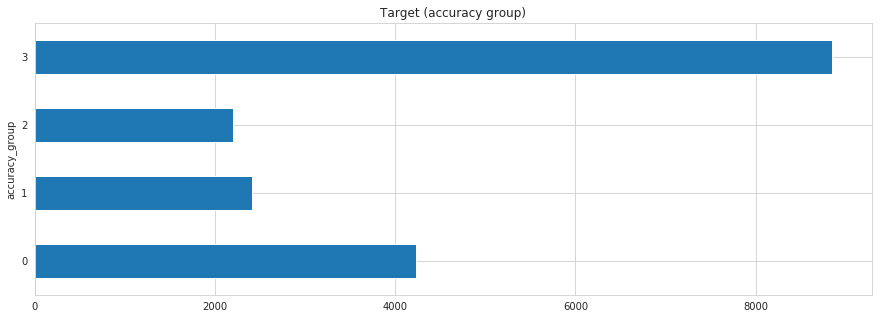

In [31]:
# target
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Target (accuracy group)')
plt.show()

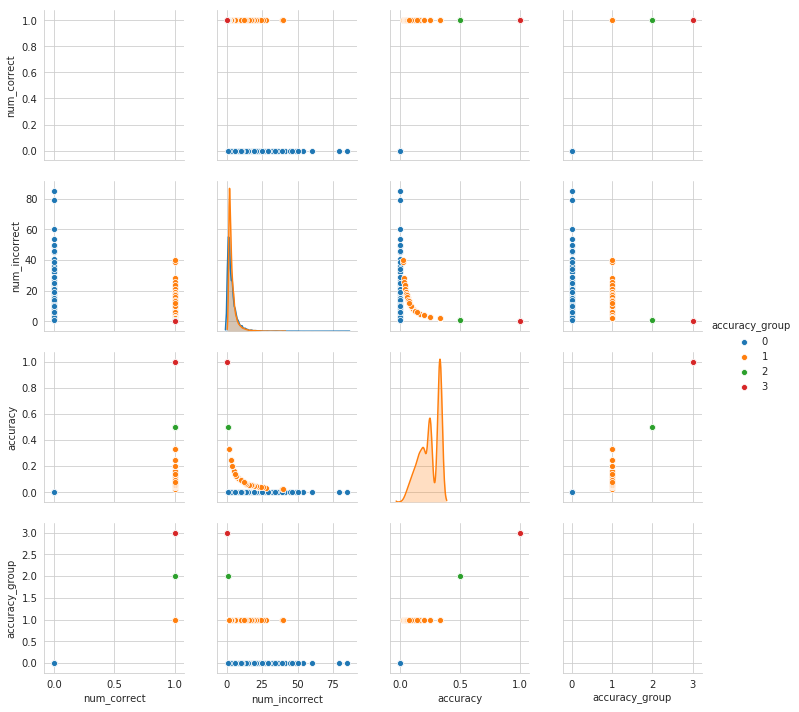

In [32]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

Text(0.5, 1.0, 'Counts of titles')

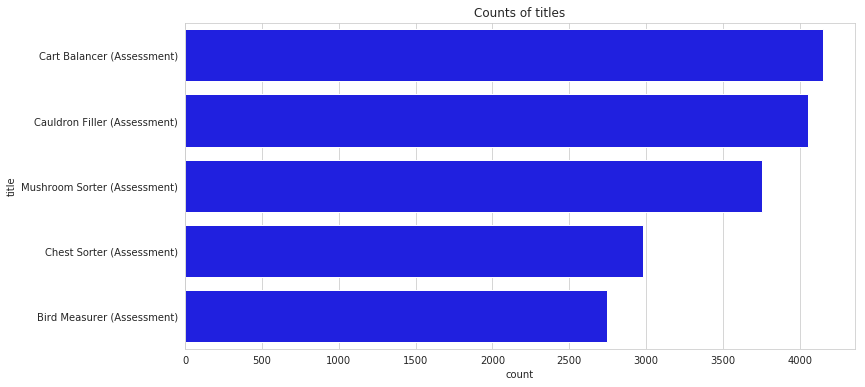

In [33]:
# count of title
plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, color="blue", order = train_labels.title.value_counts().index)
plt.title("Counts of titles")

Text(0.5, 1.0, 'Counts of accuracy group')

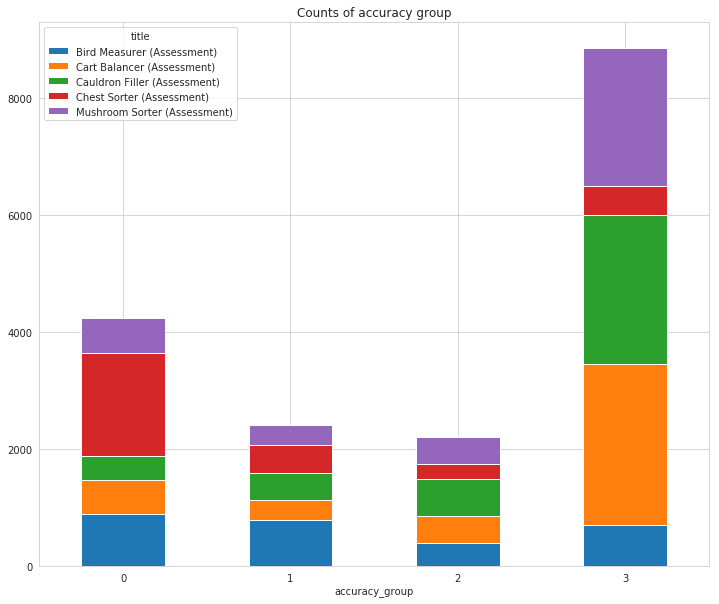

In [34]:
se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked=True, rot=0, figsize=(12,10))
plt.title("Counts of accuracy group")
# you can see that a lot of Chest Sorter assessments were never solved.
# Bird Measurer also seems hard with a relatively small amount solved on the first attempt.
# which means that there's difference in the difficulty of games

As the match between the train dataframe and the train_labels dataframe is not straightforward, it tried to figure out how these dataframes are to be matched by focussing on just one particular installation_id.

In [35]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt

In [36]:
train[(train.event_code == 4100) & (train.installation_id == "0006a69f") & (train.title == "Bird Measurer (Assessment)")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time
2615,070a5291,a9ef3ecb3d1acc6a,2019-08-06 20:50:33.283000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",0006a69f,30,4100,34209,Bird Measurer (Assessment),Assessment,TREETOPCITY,118117009,12245074954468117610,2019-08-06,20,Tuesday,10.440273


When we exclude the Bird Measurer/4100 rows we get the correct match with the numbers in train_labels for this installation_id (4 correct, 12 incorrect)

In [37]:
train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title != 'Bird Measurer (Assessment)') & (train.event_code == 4100))]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,637176564,10383836262352397729,2019-08-06,5,Tuesday,10.342130
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.484921
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.664434
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.766145
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.831825
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.911865
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.973031
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.039026
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.114908
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.198995


Now the question arises: Could there be installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? As you can see below, yes there are 628 examples.

In [38]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

# test.csv

In [39]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-09-10,16,Tuesday
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-09-10,16,Tuesday
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,2019-09-10,16,Tuesday
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,2019-09-10,16,Tuesday
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES,2019-09-10,16,Tuesday


In [40]:
test.shape

(1156414, 14)

In [41]:
print(test.installation_id.nunique())
print(ss.shape[0])
# So we have 1.1 million rows on a thousand unique installation_ids in the test set. 
# Below, you can see that we have this same amount of rows in the sample submission.
# This means that there are no installation_ids without assessment in the test set indeed.

1000
1000


In [42]:
set(train.columns) & set(train_labels.columns) # trainには関係ない？game_sessionの情報もある

{'game_session', 'installation_id', 'title'}

# specs.csv

In [43]:
specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
event_id    386 non-null object
info        386 non-null object
args        386 non-null object
dtypes: object(3)
memory usage: 9.2+ KB


In [44]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,e7561dd2,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
freq,1,17,25


In [45]:
specs.head(5)

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
